In [1]:
import datetime
import pandas as pd
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import storage
from datetime import date, timedelta
import urllib.request, json 
import time
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import os
import csv


In [2]:
cred = credentials.Certificate("serene-2dfd6-firebase-adminsdk-gfc6o-a312184978.json")
app = firebase_admin.initialize_app(cred ,  {
    'storageBucket': 'serene-2dfd6.appspot.com',
}, name='[DEFAULT]')
db = firestore.client()

In [3]:
# get from app 
duration = 2
userID = "UqTdL3T7MteuQHBe1aNfSE9u0Na2"

## Generate unique ID

In [4]:
# generate report unique ID
today = datetime.datetime.now()
timestamp = today.strftime("%Y-%m-%d %H:%M:%S")
reportId = userID +" "+ timestamp
reportId = reportId.replace(" ","_")

In [5]:
# write to a collection 
doc_ref = db.collection(u'LastGeneratePatientReport').document('tt')
doc_ref.set({
    u'name':'raghad from python',
    u'age':'21'
})

update_time {
  seconds: 1584941272
  nanos: 603258000
}

In [6]:
# store to firebase storage 
bucket = storage.bucket(app=app)
imagePath = "image.png"
imageBlob = bucket.blob("7KXzpejWaRgyuZG9zcKttgaKd002/DoctorReport/python_img")
imageBlob.upload_from_filename(imagePath)

FileNotFoundError: [Errno 2] No such file or directory: 'image.png'

## get list of included dates  

In [7]:
#get a a list of date between start and end date 
dates =[]
for x in range(0 ,duration):
    start_date = (date.today()-timedelta(days=duration-x)).isoformat()
    dates.append(start_date)

## Generate a compelete DF

In [8]:
df= pd.DataFrame()
# loop through the storage and get the data
sleep =[]
for x in range(0 ,len(dates)):
    #Sleep
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-sleep.json")
    # download the file 
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        sleepMinutes = data['summary']["totalMinutesAsleep"]
        
    #Activity (Steps)
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-activity.json")
    # download the file 
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        steps = data['summary']["steps"]
    
    #heartrate
    blob = bucket.blob(userID+"/fitbitData/"+dates[x]+"/"+dates[x]+"-heartrate.json")
    u = blob.generate_signed_url(datetime.timedelta(seconds=300), method='GET')
    with urllib.request.urlopen(u) as url:
        data = json.loads(url.read().decode())
        df_heartrate = pd.DataFrame(data['activities-heart-intraday']['dataset'])
    df_heartrate.time.apply(str)
    df_heartrate['time'] = pd.to_datetime(df_heartrate['time'])
    df_heartrate['hour'] = df_heartrate['time'].apply(lambda time: time.strftime('%H'))
    df_heartrate.drop(['time'],axis=1, inplace = True)
    heart_rate = df_heartrate.groupby(["hour"], as_index=False).mean()
    heart_rate['sleep'] = sleepMinutes
    heart_rate['steps'] = steps
    heart_rate['date'] = dates[x]
    heart_rate = heart_rate.astype({"hour": int})  
    
    
    # append dataframe
    df = df.append(heart_rate, ignore_index = True)


In [39]:
df.head(5)

,hour,value,sleep,steps,date
0,0,90.644068,464,2198,2020-03-28
1,1,92.933333,464,2198,2020-03-28
2,2,85.016667,464,2198,2020-03-28
3,3,89.900000,464,2198,2020-03-28
4,4,86.423729,464,2198,2020-03-28


In [23]:
# get location from database
loc_df = pd.DataFrame()
locations = db.collection(u'PatientLocations').where(u'patientID', u'==', userID ).stream()

for location in locations:
    loc = location.to_dict()
    loc_df = loc_df.append(pd.DataFrame(loc,index=[0]),ignore_index=True)
       


        


In [24]:
loc_df.drop(['anxietyLevel', 'lat','lng','lon', 'patientID'  ], axis=1, inplace = True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-cc2654ca6819>", line 1, in <module>
    loc_df.drop(['anxietyLevel', 'lat','lng','lon', 'patientID'  ], axis=1, inplace = True)
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py", line 3940, in drop
    errors=errors)
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 3780, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 3812, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4965, in drop
    '{} not found in axis'.format(labels[mask]))
KeyError: "['lon'] not found in axis"

During handling of the above exception, another exce

KeyError: "['lon'] not found in axis"

In [25]:
loc_df.tail(5)

,anxietyLevel,lat,lng,name,patientID,time
116,1,24.755278,46.632312,Al Aqiq,UqTdL3T7MteuQHBe1aNfSE9u0Na2,2020-03-28 23:08:37.041000+00:00
117,2,24.755278,46.632312,Al Aqiq,UqTdL3T7MteuQHBe1aNfSE9u0Na2,2020-03-28 02:26:10+00:00
118,2,24.721435,46.614162,King Saud University,UqTdL3T7MteuQHBe1aNfSE9u0Na2,2020-02-27 02:05:05+00:00
119,2,24.799209,46.580085,Al Malqa,UqTdL3T7MteuQHBe1aNfSE9u0Na2,2020-03-01 01:15:00+00:00
120,3,24.595528,46.693326,As Suwaidi,UqTdL3T7MteuQHBe1aNfSE9u0Na2,2020-03-24 11:14:13+00:00


In [26]:
loc_df.time.apply(str)
loc_df['time'] = pd.to_datetime(loc_df['time'])
loc_df['hour'] = loc_df['time'].apply(lambda time: time.strftime('%H'))
loc_df.drop(['time'],axis=1, inplace = True)
loc_df.hour = loc_df.hour.astype(int)

In [30]:
loc_df.date = loc_df.date.astype(str)

In [38]:
loc_df.head()

,anxietyLevel,lat,lng,name,patientID,hour
0,1,24.755278,46.632312,Al Aqiq,UqTdL3T7MteuQHBe1aNfSE9u0Na2,19
1,1,24.755278,46.632312,Al Aqiq,UqTdL3T7MteuQHBe1aNfSE9u0Na2,19
2,1,24.862388,46.592138,Al Qirawan District,UqTdL3T7MteuQHBe1aNfSE9u0Na2,16
3,1,24.755278,46.632312,Al Aqiq,UqTdL3T7MteuQHBe1aNfSE9u0Na2,2
4,1,24.755278,46.632312,Al Aqiq,UqTdL3T7MteuQHBe1aNfSE9u0Na2,20


In [37]:
#merge dataframe

dfinal = pd.merge(left=df, right = loc_df,left_on=['hour','date'],right_on=['hour','date'])




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-bb417cb92034>", line 3, in <module>
    dfinal = pd.merge(left=df, right = loc_df,left_on=['hour','date'],right_on=['hour','date'])
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py", line 47, in merge
    validate=validate)
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py", line 529, in __init__
    self.join_names) = self._get_merge_keys()
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py", line 833, in _get_merge_keys
    right._get_label_or_level_values(rk))
  File "//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 1706, in _get_label_or_level_values
    raise KeyError(key)
KeyError: 'date'

During handling of the above exception, another exception occurred:

Trace

KeyError: 'date'

In [36]:
dfinal.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-2325bba3a2dd>", line 1, in <module>
    dfinal.head()
NameError: name 'dfinal' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", lin

NameError: name 'dfinal' is not defined

In [ ]:
#dfinal.to_csv('full.csv')

In [ ]:
#test model 


# Plot

## HR

In [ ]:
# plot HR
fig1 = plt.gcf()
plt.plot(df['hour'], df['value'])
plt.xlabel('hour')
plt.ylabel('bpm')
plt.show()
plt.draw()
fig1.savefig('hr.png', dpi=100)
# store HR to firebase
imagePath = "hr.png"
imageBlob = bucket.blob(userID+"/DoctorReport/heartrate")
imageBlob.upload_from_filename(imagePath)
os.remove("hr.png")

In [ ]:
# plot Sleep
# max plot a 15 date only 
fig1 = plt.gcf()
plt.plot(df['date'], df['sleep'])
plt.xlabel('date')
plt.ylabel('sleep')
plt.tick_params(axis='x', rotation=70)
plt.show()
plt.draw()
fig1.savefig('sleep.png', dpi=100)
# store HR to firebase
imagePath = "sleep.png"
imageBlob = bucket.blob(userID+"/DoctorReport/sleep")
imageBlob.upload_from_filename(imagePath)
os.remove("sleep.png")

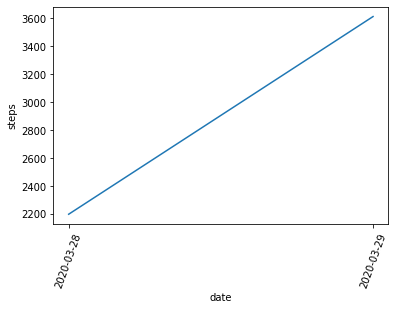

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-4e6ed783b794>", line 16, in <module>
    plot_steps_short_duration()
  File "<ipython-input-40-4e6ed783b794>", line 8, in plot_steps_short_duration
    fig1.savefig('steps.png', dpi=100)
NameError: name 'fig1' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getin

NameError: name 'fig1' is not defined

<Figure size 432x288 with 0 Axes>

In [40]:
def plot_steps_short_duration():
    plt.plot(df['date'], df['steps'])
    plt.xlabel('date')
    plt.ylabel('steps')
    plt.tick_params(axis='x', rotation=70)
    plt.show()
    plt.draw()
    fig1.savefig('steps.png', dpi=100)
    # store HR to firebase
    imagePath = "steps.png"
    imageBlob = bucket.blob(userID+"/DoctorReport/steps")
    imageBlob.upload_from_filename(imagePath)
    os.remove("steps.png")

In [ ]:
def plot_steps_long_duration():
    

In [ ]:
if( duration >15)
    plot_steps_long_duration()
else 
    plot_steps_short_duration()
    
    